In [1]:
import requests

url = ("https://raw.githubusercontent.com/rasbt/"
       "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
       "the-verdict.txt")
file_path = "the-verdict.txt"

response = requests.get(url)
with open(file_path, 'w', encoding='utf-8') as f:
    f.write(response.text)

In [2]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


Our goal is to tokenize the 20479 words.

In [3]:
import re
text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


This simple tokenization scheme mostly works for separating the example text into individual words; however, some words are still connected to punctuation characters that we want to have as separate list entries. We also refrain from making all text lowercase because capitalization helps LLMs distinguish between proper nouns and common nouns, understand sentence structure, and learn to generate text with proper capitalization.

In [4]:
result = re.split(r'([,.]|\s)', text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [5]:
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


Our tokenizer:

In [6]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


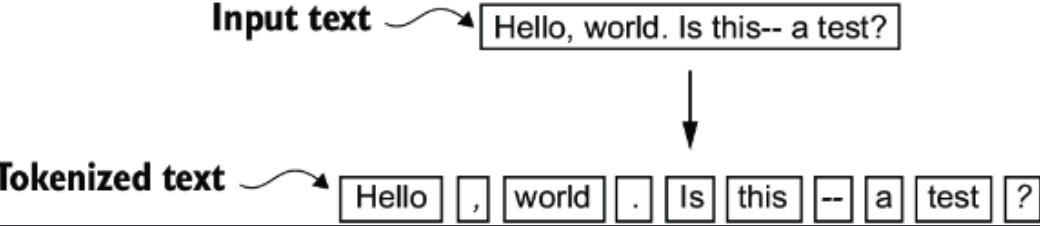

In [7]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


In [8]:
print(preprocessed[:10])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius']


Converting tokens into token IDs

In [9]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


In [10]:
vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


Implementing a simple text tokenizer

In [11]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab            #Stores the vocabulary as a class attribute for access in the encode and decode methods
        self.int_to_str = {i:s for s,i in vocab.items()}        #Creates an inverse vocabulary that maps token IDs back to the original text tokens

    def encode(self, text):         #Processes input text into token IDs
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):         #Converts token IDs back into text
        text = " ".join([self.int_to_str[i] for i in ids]) 

        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)    #Removes spaces before the specified punctuation
        return text

Adding special token

In [12]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}

print(len(vocab.items()))

1132


In [13]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        preprocessed = [item if item in self.str_to_int            #1
                        else "<|unk|>" for item in preprocessed]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])

        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)    #2
        return text

In [14]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [15]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


Sanity check

In [16]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


## Byte-pair encoding (BPE)

In [17]:
!pip install tiktoken

In [18]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.9.0


Initiation

In [19]:
tokenizer = tiktoken.get_encoding("gpt2") #tokenizer is something siimilar to our SimpleTokenizerV2 class

In [20]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


Decoding method

In [21]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


The reason why BPE does not need tokens for unknown words

In [22]:
text = ("Akwirw ier")
integers = tokenizer.encode(text)
print(integers)

[33901, 86, 343, 86, 220, 959]


In [23]:
strings = tokenizer.decode(integers)
print(strings)

Akwirw ier


Now encoding the Verdict text

In [24]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


Removing the first 50 tokens

In [25]:
enc_sample = enc_text[50:]

In [26]:
context_size = 4  #The context size determines how many tokens are included in the input.
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


Next word prediction generation task:

In [27]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


Now converting it back to texts

In [28]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


In [29]:
!pip install torch

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt) # tokenize the entire text

        for i in range(0, len(token_ids) - max_length, stride): # Uses a sliding window to chunk the book into overlapping sequences of max_length
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self): # Returns the total number of rows in the dataset
        return len(self.input_ids)

    def __getitem__(self, idx): # Returns a single row from the dataset
        return self.input_ids[idx], self.target_ids[idx]

In [31]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2") # Initializes the tokenizer
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)   # Create dataset
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,     # drop_last=True drops the last batch if it is shorter than the specified batch_size to prevent loss spikes during training
        num_workers=num_workers     #  The number of CPU processes to use for preprocessing
    )

    return dataloader

In [32]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader) #Converts dataloader into a Python iterator to fetch the next entry via Python’s built-in next() function
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [33]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=4, stride=4,
    shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


Creating token embeddings

In [34]:
input_ids = torch.tensor([2, 3, 5, 1])
vocab_size = 6
output_dim = 3

In [35]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


The nn.Embedding layer skips the steps of building a one-hot encoding and then multiplying it with the embedding matrix. Instead, it directly maps the token IDs to their corresponding embeddings.

In [36]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


Encoding word positions

Initiating a data loader

In [37]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
   stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [38]:
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [39]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
   stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


The token ID tensor is 8 × 4 dimensional, meaning that the data batch consists of eight text samples with four tokens each.

In [40]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [42]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])
